<center><strong>A Journey Into Math For Machine Learning</strong></center>
<center><strong>机器学习之数学之旅</strong></center>
<center><strong>之 自适应增强$adaboost$$(adaptive \ boosting)$</strong></center>

![title](boosting.gif)

今天的主题是集成学习中的$adaboost$, 或称作$adaptive \ boosting$, 首先我们来建立一种概念, 什么是$adaptive \ boosting$:
$adaboost$是集成学习的一种, 意思是建立多个所分类器, 然后用这些弱分类器的线性加权组合来形成一个强分类器, 什么是弱分类器呢, 就是只比胡猜稍微好一点的分类器, 训练这些弱分类器是一个迭代的过程, 在这个过程里, 下一个弱分类器总是更加关注上一个弱分类器没有分好的数据样本, 以弥补之前弱分类器的不足, $adaboost$就是类似"三个臭皮匠顶个诸葛亮"的算法.    

课程预览:   
(一). 建立一种直觉——$adaboost$的可视化;   
(二). 从零推导$adaboost$;   
(三). $adaboost$的特性;   
(四). 代码解读.   

首先我们先来通过可视化的方法来建立一种直觉.

In [1]:
from demonstration import *
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# 在jupyter notebook之内画图
init_notebook_mode(connected=True)

我们首先造一些数据, 并把它们画出来:

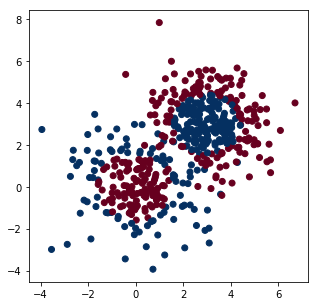

In [115]:
from sklearn.datasets import make_gaussian_quantiles
# 画两个正态分布的群
X1, y1 = make_gaussian_quantiles(cov=2.,
                                 n_samples=200, n_features=2,
                                 n_classes=2, random_state=1)
X2, y2 = make_gaussian_quantiles(mean=(3, 3), cov=1.5,
                                 n_samples=300, n_features=2,
                                 n_classes=2, random_state=1)
X=np.concatenate([X1,X2])
y=np.concatenate([y1,1-y2])
plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu)
y[np.where(y == 0)] =-1

In [3]:
A = Adaboost_Demonstration(X, y)

每次运行\_\_next\_\_函数, 都会新增加一个弱分类器, 并对当前的强分类器的分类边界进行可视化

In [103]:
A.__next__(plot=True, plot_mode="3d")

(二). 从零推导$adaboost$:   
我们首先有一个弱分类器$h(x)$, 它输出的值非$1$即$-1$, $h(x) \in \{1, -1\}$, $adaboost$的思路是把这些弱分类器的预测结果都加起来, 然后取他们的均值, 在我们的推导过程中, 假设我们要解决的问题是一个二项分类问题, 则我们要把这些弱分类器都加起来取$sign$, 则有:
$$H(x)=sign(\sum_{t=1}^T h^t(x))$$
上式中$H(x)$是一个强分类器, $x$是数据或特征值, $t$指的是弱分类器的个数, 上式的意思是对弱分类器的输出值求和并取$sign$, $H(x) \in \{1, -1\}$   

然后我们发现只对弱分类器求和好像少了点什么, 没错, 我们要赋予每个弱分类器不同的权重:
$$H(x)=sign(\sum_{t=1}^T \alpha^t h^t(x))$$
上式中$\alpha$指的是第$t$个弱分类器的权重.   
在$adaboost$中, 这么多弱分类器, 是凭什么依据划分的呢, 其实每个弱分类器关注的是前面弱分类器没有分对的数据样本, 比如说第$t$个弱分类器犯了一些错误, 导致有些数据样本没有分对, 那么第$t+1$个弱分类器就会更加关注前面没有分对的数据点, 尝试弥补第$t$个弱分类器的不足.

假设我们有一些数据样本$\{(x_{1},y_{1}),\ldots ,(x_{N},y_{N})\}$, 其中$y_{i}\in \{-1,1\}$, $N$是数据样本的个数, 我们要解决的是二项分类问题.   
我们需要给每一个数据样本赋一个权重, 以控制每个弱分类器应该更加关注哪些数据样本, 我们需要让下一个弱分类器更加关注它前面的弱分类器没有分对的数据点, 设$x_i$在第$t$个弱分类器上的权重为$w^t$, 我们首先初始化, 在第$1$个弱分类器上所有数据点的权重都是一样的, 即:
$$w^{t=1}_i=\frac{1}{N}$$
初始化错误率$\epsilon$为, 比如说$100$个数据点, 分错了40个, 则$\epsilon=0.4$, $\epsilon$取值在$0$到$1$之间:
$$\epsilon=\sum_{y_i \neq h_i(x)}\frac{1}{N} \quad \epsilon \in [0, 1]$$
将$w_i$代入$\epsilon$, 得出:
$$\epsilon=\sum_{y_i \neq h_i(x)}w_i \quad \sum w_i =1$$
那我们怎么确定下一个弱分类器需要关注哪些数据样本呢? 当我们定义好当前的弱分类器$h^t(x)$之后, 做以下操作:
$$w^{t+1}_{i}=\frac{w^{t}_{i}}{Z}e^{-\alpha^t h^t(x_i) y_i}$$
上式中$Z$是归一化因子, 因为我们想要$\sum w_i =1$, 怎么理解这个式子呢, 首先$\alpha$是正数, 当$h^t(x_i)=y_i$的时候, $h^t(x_i)y_i$的是$1$, 否则是$-1$, 不难看出当当前弱分类器$h^t(x_i)$预测正确的时候, $w^{t+1}=$会变小, 而错误的时候, $w^{t+1}$会变大:
$${\displaystyle w^{t+1}_{i}={\begin{cases} \frac{1}{Z} w_{i}^{t}e^{-\alpha ^{t}}&{\text{if }}y_{i}=h^{t}(x_{i}),
\\ \frac{1}{Z} w_{i}^{t}e^{\alpha ^{t}}&{\text{if }}{y_{i} \neq h^{t}(x_{i})}.\end{cases}}}\tag{eq. 2}$$
注意我们暂且不管$Z$.

$$\epsilon^{t+1}=\sum_{i=1}^{N}w^{t+1}=\frac{1}{Z}(
\sum _{y_{i}=h^{t}(x_{i})}w_{i}^{t}e^{-\alpha ^{t}}+\sum _{y_{i}\neq h^{t}(x_{i})}w_{i}^{t}e^{\alpha ^{t}})$$
右式左边加上$\sum _{y_{i}\neq h^{t}(x_{i})} w_{i}^{t} e^{-\alpha ^{t}}$, 右边再减去.
$$\epsilon^{t+1}=\frac{1}{Z}(
\sum _{i=1}^{N}w_{i}^{t} e^{-\alpha ^{t}}+\sum _{y_{i}\neq h^{t}(x_{i})}w_{i}^{t}(e^{\alpha ^{t}} |- e^{-\alpha ^{t}}))$$
上式中可看出, 上式左边相当于一个常数, 右边才控制着最终的错误率$\epsilon^{t+1}$的大小, 为了得到我们想要的$\alpha$, 我们要求$\epsilon^{t+1}$对于$\alpha^{t}$的导数, 并把它设为$0$, 求出$\alpha^{t}$的值, 注意下边我们会把等式左边省略掉, 因为它可看作一个常数.

$${\frac {d \epsilon^{t+1}}{d\alpha ^{t}}}=\frac{1}{Z}(-\sum _{y_{i}= h^{t}(x_{i})}w_{i}^{t}e^{-\alpha ^{t}}+\sum _{y_{i}\neq h^{t}(x_{i})}w_{i}^{t}e^{\alpha ^{t}})=0$$
解上面的式子, 这里省略过程, 因为比较简单, 大概解法是将$e^{\alpha ^{t}}$和$e^{-\alpha ^{t}}$提到求和符号外面来, 同时取$\log$, 化简, 得到$\alpha^{t}$:
$$\alpha ^{t}={\dfrac {1}{2}}\log \left({\dfrac {\sum _{y_{i}=h^{t}(x_{i})}w_{i}^{t}}{\sum _{y_{i}\neq h^{t}(x_{i})}w_{i}^t}}\right)={\dfrac {1}{2}}\log  \left(\dfrac {1-\epsilon^{t}}{\epsilon^{t}}\right)  $$
将$\alpha ^{t}$带入到$(eq. 2)$里, 得到下式, 注意这里用到了$e^{log_e(x)}=x$:
$${\displaystyle w^{t+1}_{i}=\frac{1}{Z} w_{i}^{t}{\begin{cases}  \sqrt{\frac{\epsilon^{t}}{1-\epsilon^{t}}} &{\text{if }}y_{i}=h^{t}(x_{i}),
\\ \sqrt{\frac{1-\epsilon^{t}}{\epsilon^{t}}} &{\text{if }}{y_{i} \neq h^{t}(x_{i})}.\end{cases}}}\tag{eq. 3}$$

我们求$Z$, $Z$是所有数据样本权重的和也就是所有$w^{t+1}_{i}$取值的和:
$$Z=\sqrt{\frac{\epsilon^{t}}{1-\epsilon^{t}}} \sum _{y_{i}= h^{t}(x_{i})}w^{t}_i +
\sqrt{\frac{1-\epsilon^{t}}{\epsilon^{t}}} \sum _{y_{i}\neq h^{t}(x_{i})}w^{t}_i$$
将$\epsilon=\sum_{y_i \neq h_i(x)}w_i$代入上式, 得出:
$$Z=\sqrt{\frac{\epsilon^{t}}{1-\epsilon^{t}}} (1-\epsilon^t) +
\sqrt{\frac{1-\epsilon^{t}}{\epsilon^{t}}} \epsilon^t=2 \sqrt{\epsilon^t(1-\epsilon^t)}$$
将$Z$代入$(eq.3)$里:
$${\displaystyle w^{t+1}_{i}={\begin{cases}  \frac{w_{i}^{t}}{2(1-\epsilon^{t})} &{\text{if }}y_{i}=h^{t}(x_{i}),
\\ \frac{w_{i}^{t}}{2\epsilon^{t}} &{\text{if }}{y_{i} \neq h^{t}(x_{i})}.\end{cases}}}\tag{eq. 4}$$

我们通过上式还是很难看出$w^{t+1}_i$的意义到底是什么, 没关系, 接下来就恍然大悟了, 下面我们求数据点中分类正确的样本和分类错误样本各自$w^{t+1}_i$的合:
$$\sum_{y_{i}=h^{t}(x_{i})}w^{t+1}_i=\frac{\sum_{y_{i}=h^{t}(x_{i})} w_{i}^{t}}{2(1-\epsilon^{t})}$$
我们又知道$\sum_{y_{i}\neq h^{t}(x_{i})} w_{i}^{t}=\epsilon^t$, 得出$\sum_{y_{i}=h^{t}(x_{i})} w_{i}^{t}=1-\epsilon^t$, 代入上式:
$$\sum_{y_{i}=h^{t}(x_{i})}w^{t+1}_i=\frac{1-\epsilon^t}{2(1-\epsilon^{t})}=\frac{1}{2}$$
又因为$\sum w_i =1$, 得出:
$$\sum_{y_{i} \neq h^{t}(x_{i})}w^{t+1}_i=1-\sum_{y_{i}=h^{t}(x_{i})}w^{t+1}_i=1-\frac{1}{2}=\frac{1}{2}$$
上式的意义是, 在我们每次增加一个新弱分类器的时候, 前面的弱分类器分错的样本的权重占总样本权重的$\frac{1}{2}$, 前面的弱分类器分对的样本的权重也占总样本权重的$\frac{1}{2}$

我们把$adaboost$的计算步骤梳理一下:
1. 初始化$w^1_i=\frac{1}{N}$;
2. 在第$t$步, 选择可以最小化当前错误率$\epsilon$的弱分类器, 并添加这个弱分类器, 以降低错误率(如果还没有弱分类器, 那就创建一个), 并计算$\alpha^t$, $\alpha ^{t}={\dfrac {1}{2}}\log  \left(\dfrac {1-\epsilon^{t}}{\epsilon^{t}}\right)$, 定义新的弱分类器为$f^t(x)=\alpha^t h^t(x))$
3. 计算新的数据样本权重$w^{t+1}_i$, 见$(eq. 4)$
4. 回到第2, 直到收敛.
5. 得到的模型为: $H(x)=sign(\sum_{t=1}^T \alpha^t h^t(x))$

(三). $adaboost$的特性:
1. 易用, 需要调节的参数少;
2. 弱分类器可以是任何模型, 比如逻辑回归, 线性回归等等, 最常用的是决策树桩;
3. 对数据敏感, 如果数据有很多噪音, 则$adaboost$会倾向于拟合噪音而最终导致模型的过拟合, 为了解决这样的问题, 可以给每一个弱分类器一个学习率权重, 让每个弱分类器最强分类器造成的影响小一些, 或做交叉验证, 让迭代的过程在合适的时机停止;
4. 可以用来做特征选择, 举个例子吧， 比如说要评估人群的信用风险, 然后你会有很多这些人的资料, 比如说性别年龄, 居住地址, 收入, 有无不动产等等, 如果你用$adaboost$的集成方法来做分类, 在迭代的每一步你需要用一个弱分类器划分数据样本, 假设我们用决策树桩， 决策树桩每次只能选择一个特征值进行划分, 在建模完成之后, 看一下模型里的弱分类器都是靠那些特征进行分类的, 就可以得出每种特征的重要性, 方便我们做特征选择, 剔除多余的特征, 增加计算效率， 减少噪音;
5. 注意, 在推导的过程中, 我们对强分类器输出的结果取$sign$, 实际中我们可以不单纯取$sign$, 而是找一个分类最好的阈值, 或者说边界, 这个阈值不一定为$0$.

(四). 代码解读.   
请参照B站或youtube视频讲解, 或参考demonstration.py文件内注释.   